In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer, BatchNormalization
from keras.callbacks import ModelCheckpoint
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
df = pd.read_csv('creditcard.csv')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

From the number of fraudulent and non-fraudulent instances, we can already understand that this dataset is very unbalanced.

In [7]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [8]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

We don't have any null values as we can see

In [9]:
df['Class'].value_counts() * 100 / len(df['Class'])

Class
0    99.827251
1     0.172749
Name: count, dtype: float64

- 99.82% of the data is not Fraud
- 0.17% is Fraud

The percentage of Fraud is very small compared to the non-fraudulent as we saw it before. Let's plot this to understand better how this is unbalanced:

<Axes: xlabel='Class', ylabel='count'>

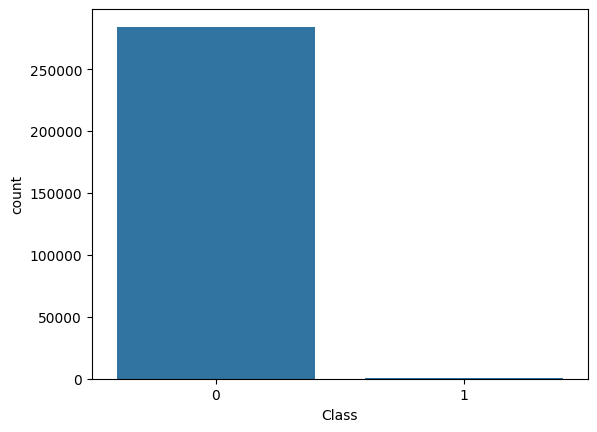

In [10]:
sns.countplot(data=df, x='Class')

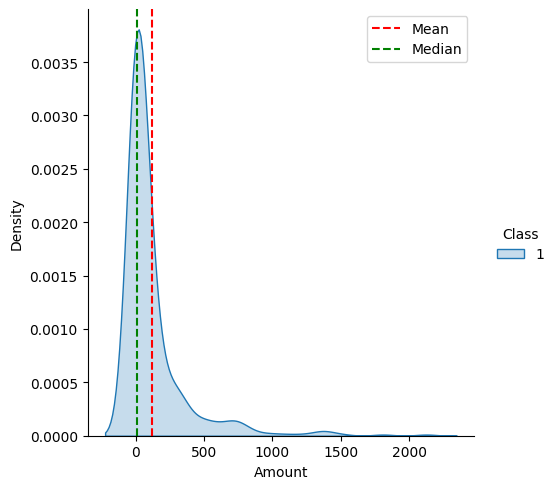

In [11]:
import seaborn as sns

fraud = df.loc[df['Class'] == 1]
fraud_amount = df.loc[df['Class'] == 1, "Amount"]
mean_amount = fraud_amount.mean()
mode_amount = fraud_amount.median()


sns.displot(data=fraud, x='Amount', hue='Class', kind='kde', fill=True)
plt.axvline(mean_amount, color='r', linestyle='--', label='Mean')
plt.axvline(mode_amount, color='g', linestyle='--', label='Median')

plt.xlabel('Amount')
plt.ylabel('Density')
plt.legend()

plt.show()

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The data is right-skewed, meaning the mean is greater than the median. This is because we have extreme outliers that impact a lot this mean. If we check the statistics, we have a standard deviation of ≈250 with a minimum of 0 and a maximum of 25691, a very wide range.

For this, we need to handle this outliers without losing information, because we're dealing with frauds and these can be easily be found in outliers.

### Handling outliers

Let's visualize the outliers in each 'Class'

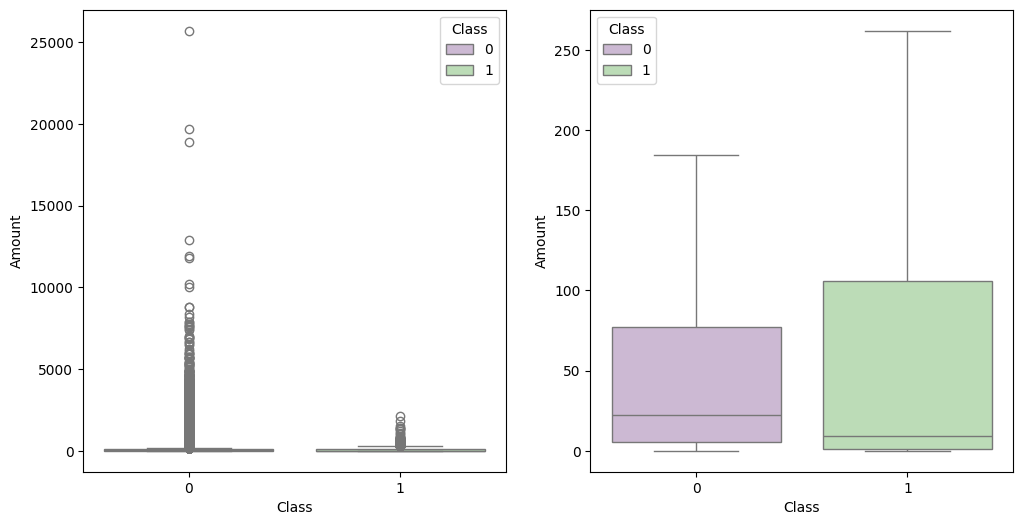

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False)
plt.show();

In [14]:
fraud_amount = df.loc[df['Class'] == 1]['Amount']
non_fraud_amount = df.loc[df['Class'] == 0]['Amount']

fraud_amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [15]:
non_fraud_amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

### IQR of fraud and non-fraud

In [16]:
fraud = df.loc[df['Class'] == 1]['Amount']
non_fraud = df.loc[df['Class'] == 0]['Amount']


Q1 = fraud.quantile(0.25)
Q3 = fraud.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('For the fraudulent transactions:\n')
print('lower bound: ', lower_bound)
print('upper bound: ', upper_bound)


Q1 = non_fraud.quantile(0.25)
Q3 = non_fraud.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('\n----------------------------------------')
print('\nFor the non-fraudulent transactions:\n')
print('lower bound: ', lower_bound)
print('upper bound: ', upper_bound)


For the fraudulent transactions:

lower bound:  -156.335
upper bound:  263.225

----------------------------------------

For the non-fraudulent transactions:

lower bound:  -101.44999999999999
upper bound:  184.14999999999998


I choose to delete the extreme values and still preserving the relative differences between data points. With this, I will use RobustScaler to scale the 'Amount' column and MinMaxScaler to scale the 'time' column.

Before scaling it, let's visualize the density plots of each feature and understand if we have overlapping features

#### Visualize the density of each feature

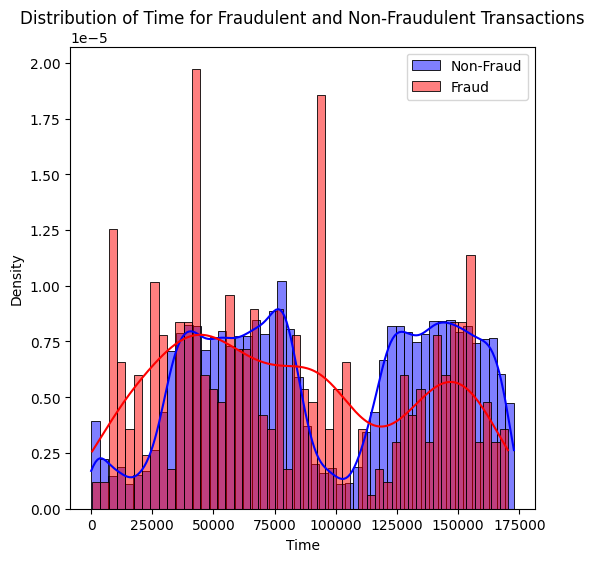

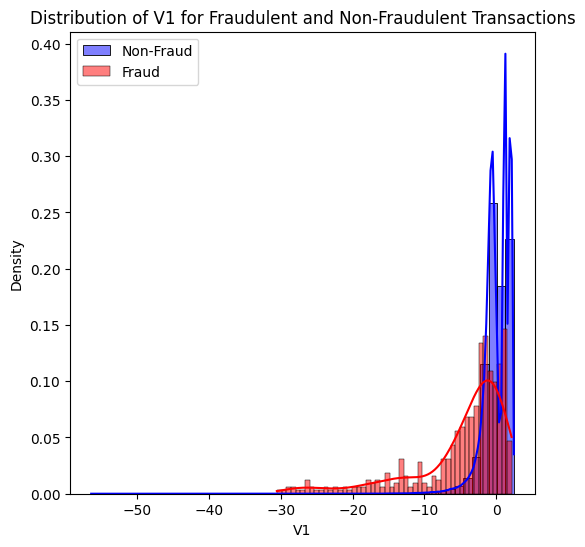

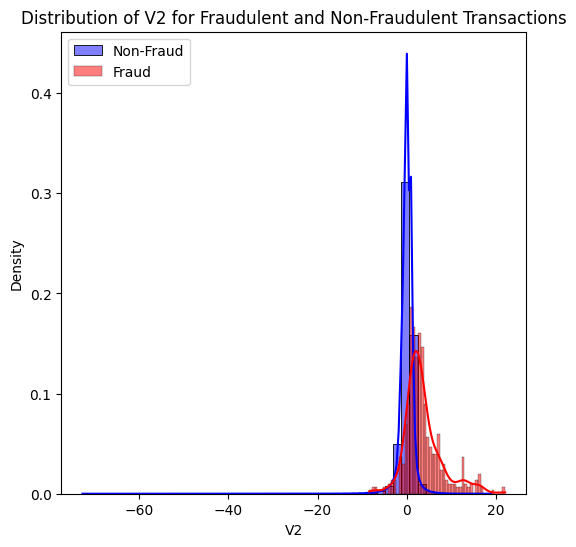

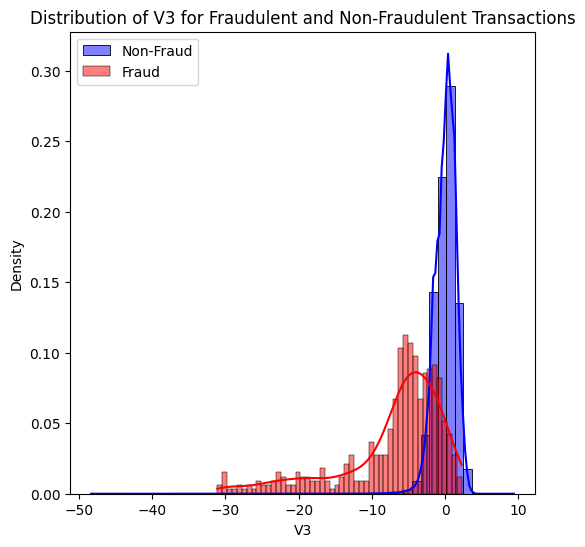

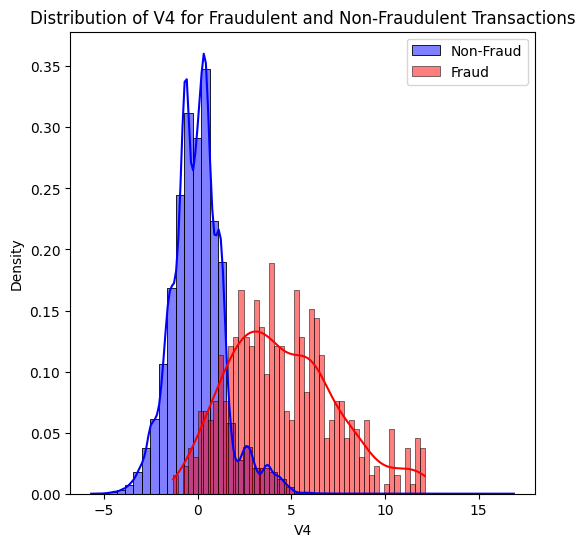

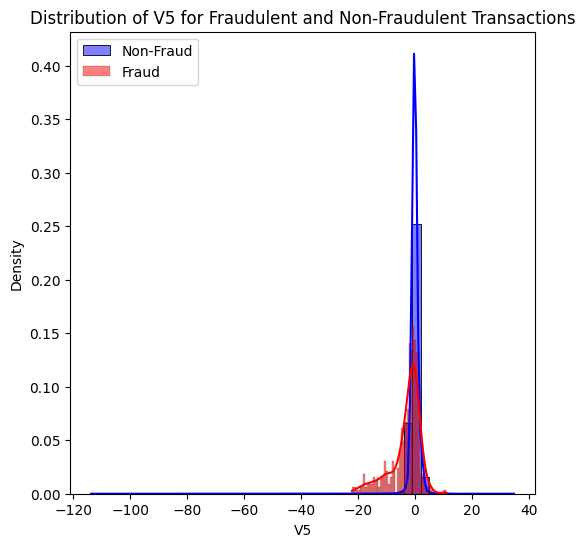

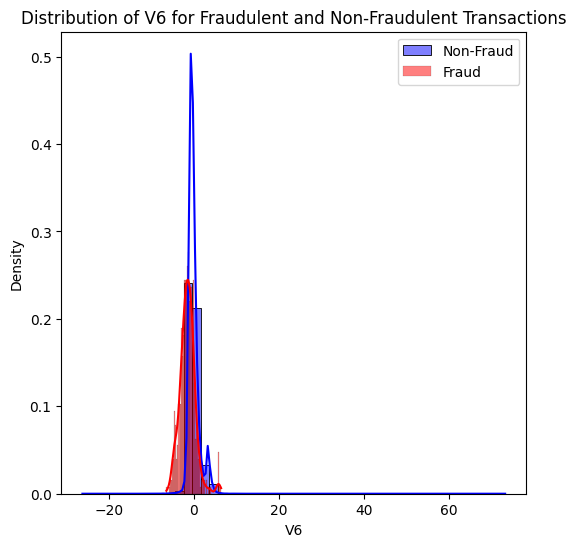

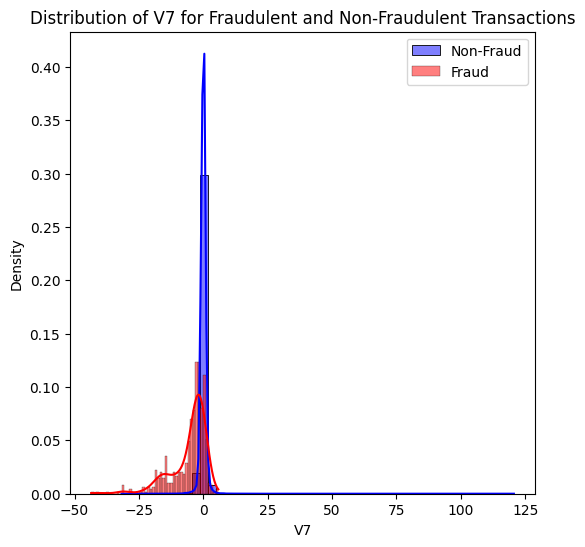

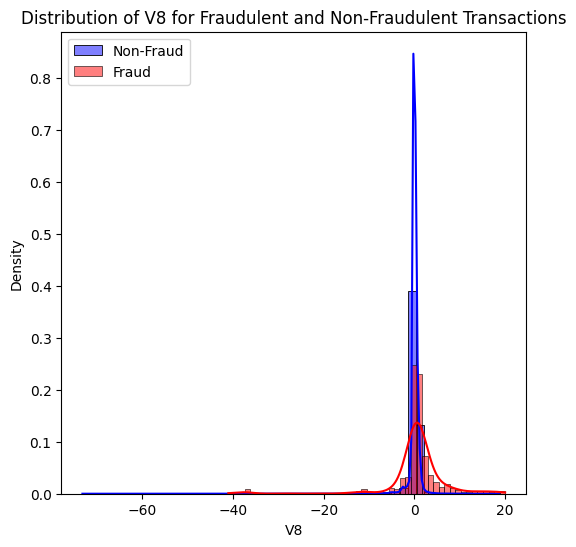

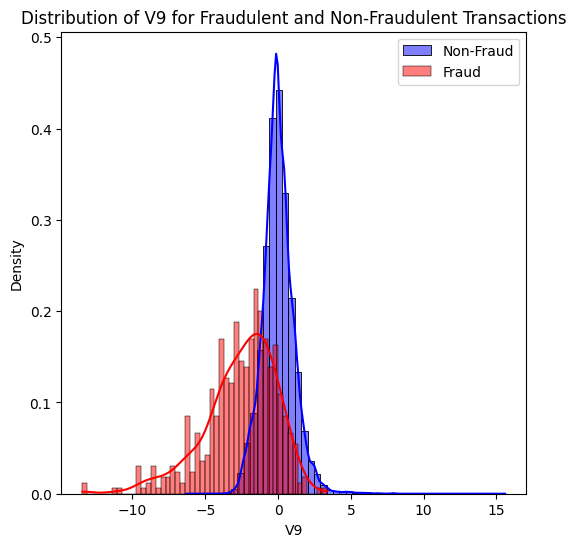

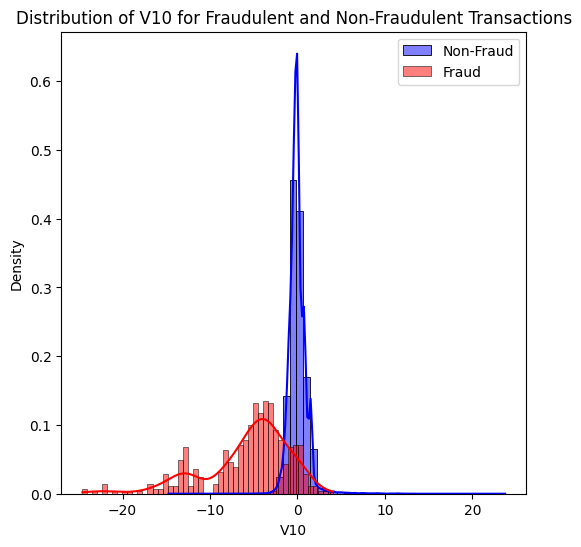

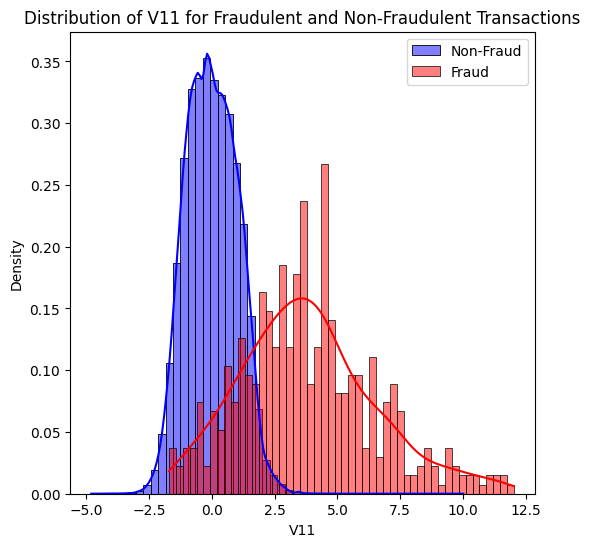

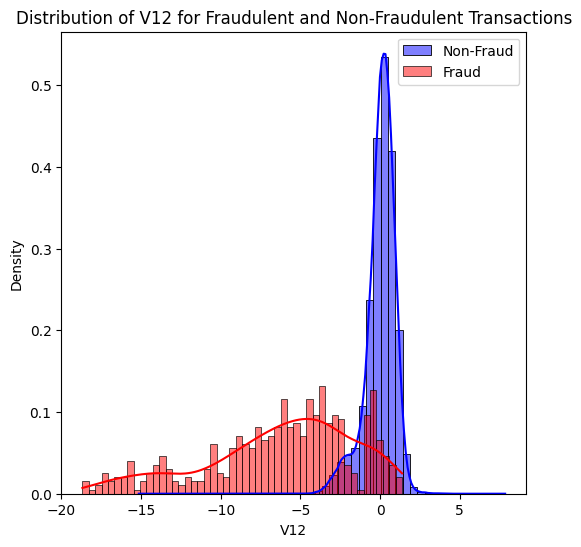

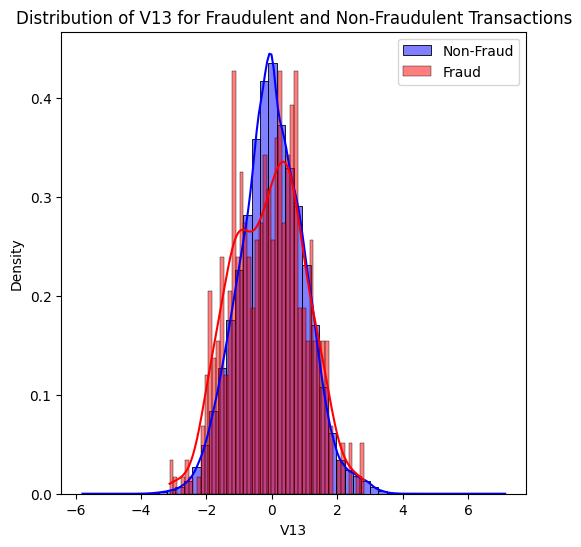

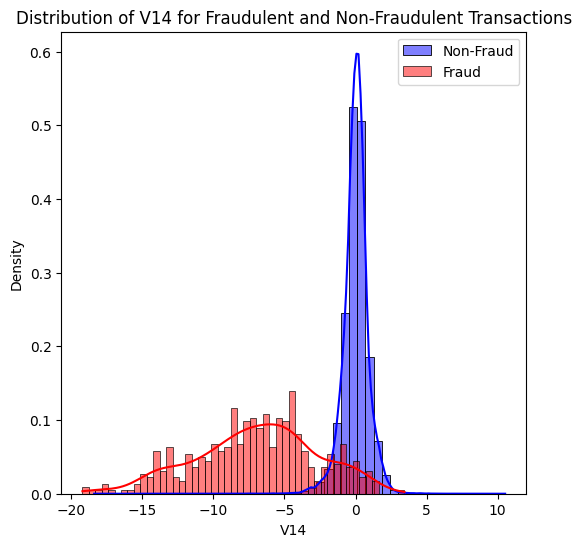

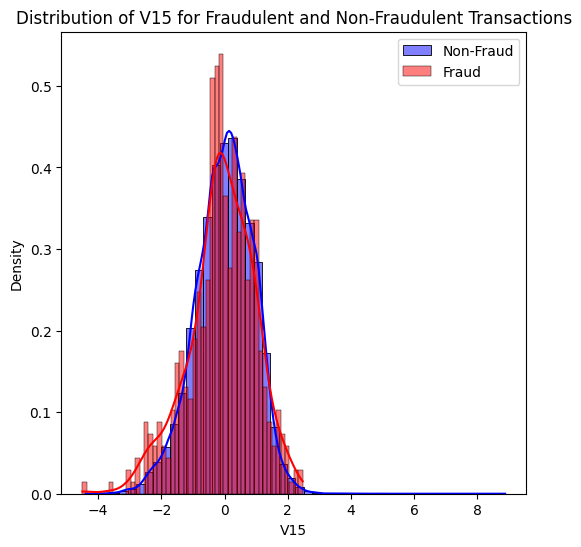

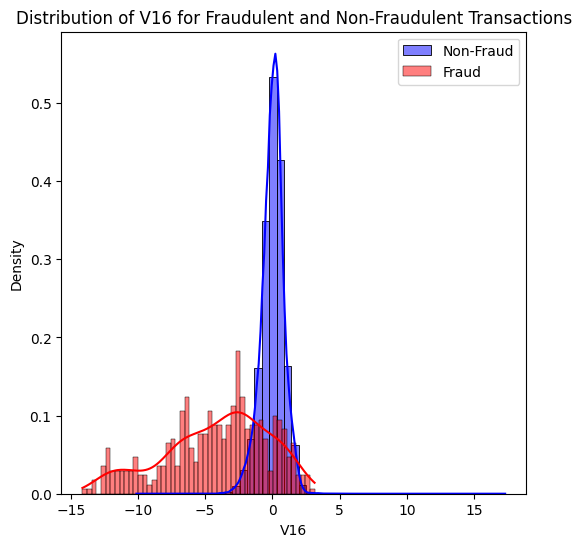

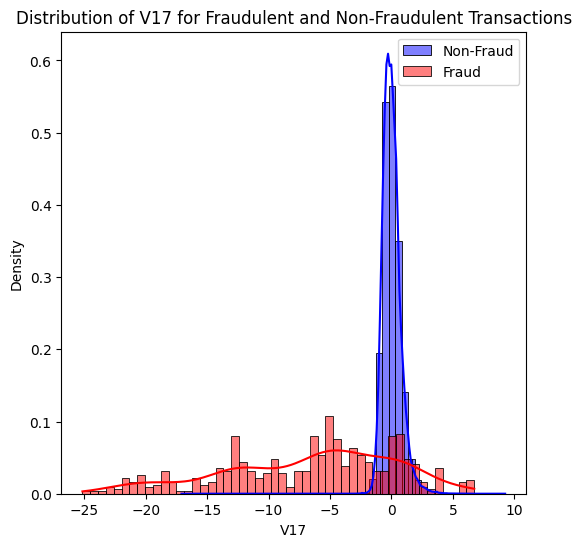

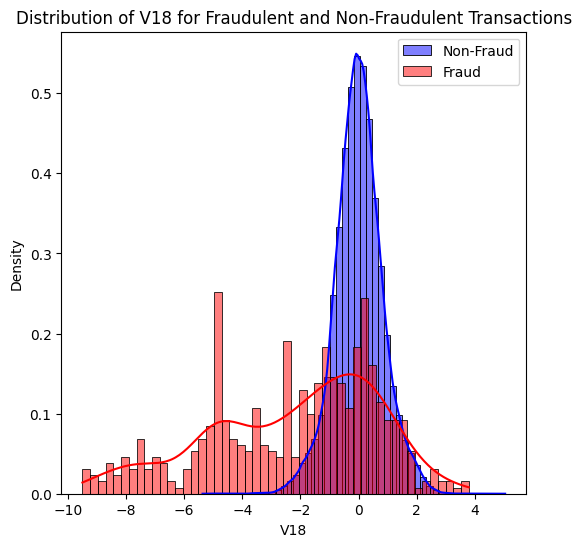

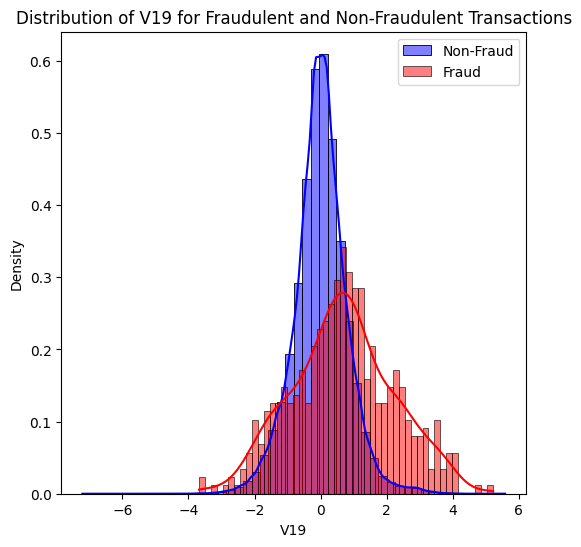

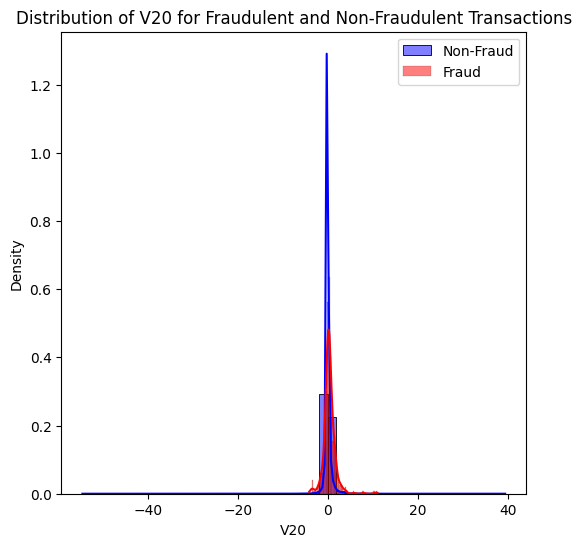

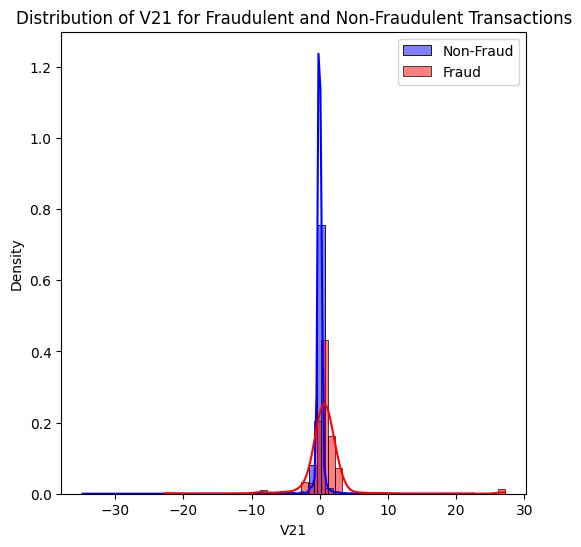

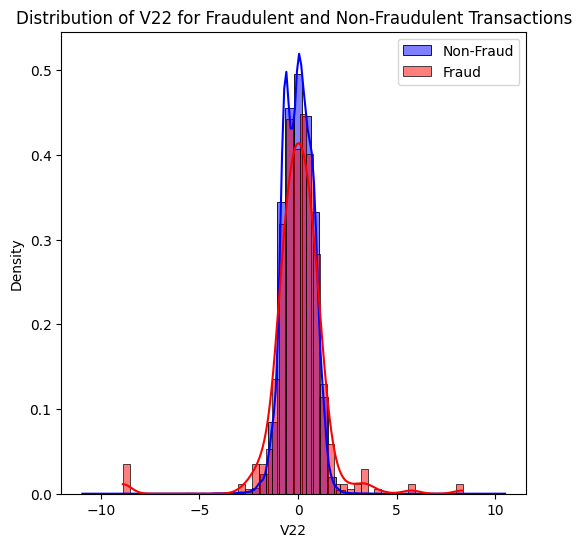

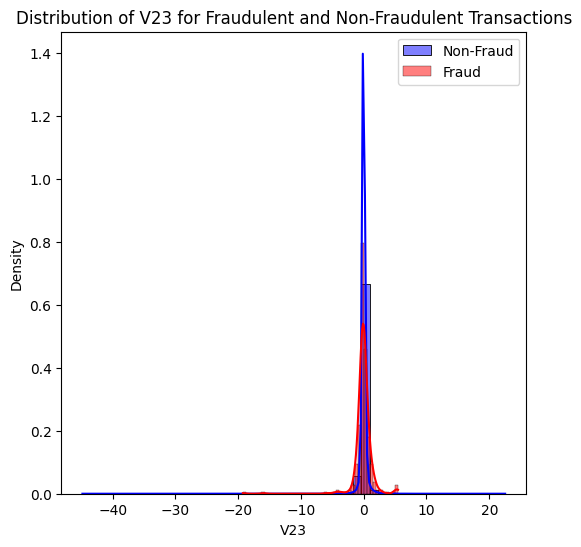

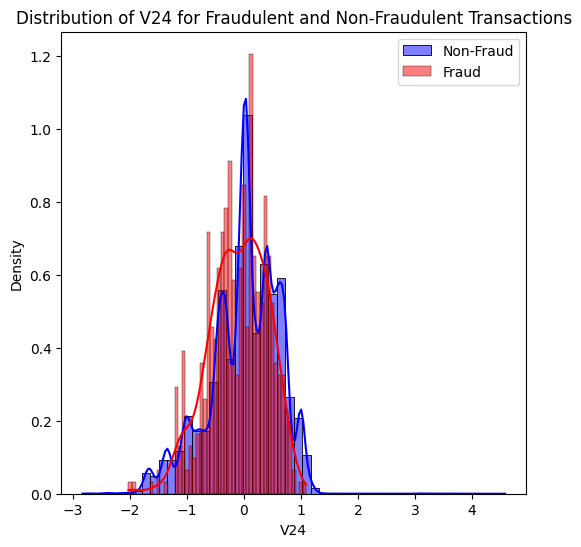

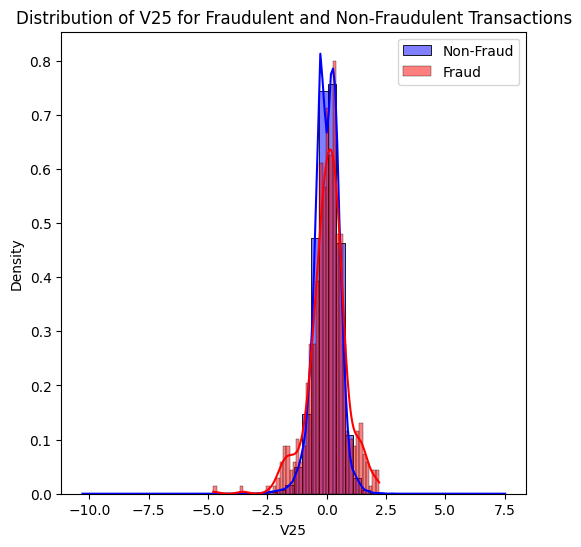

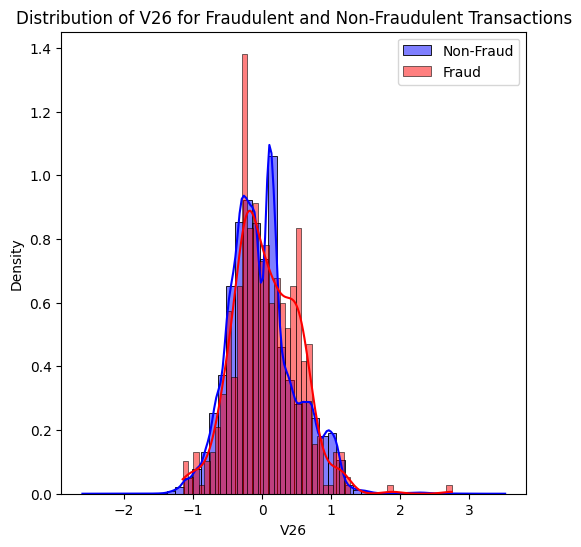

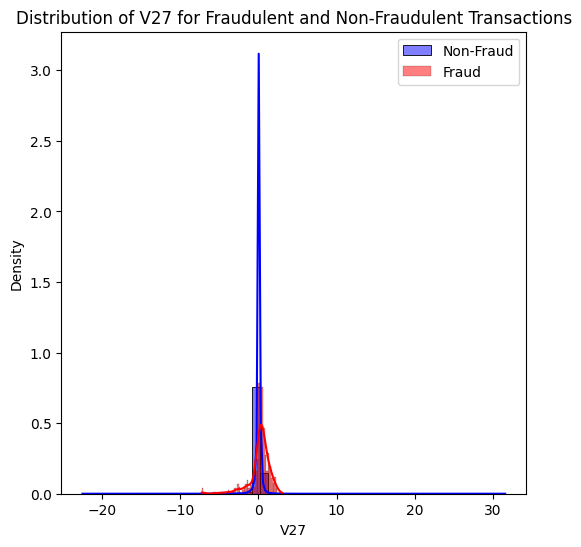

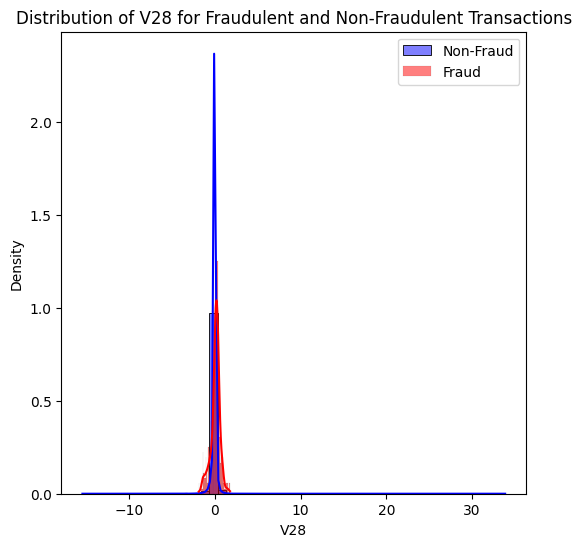

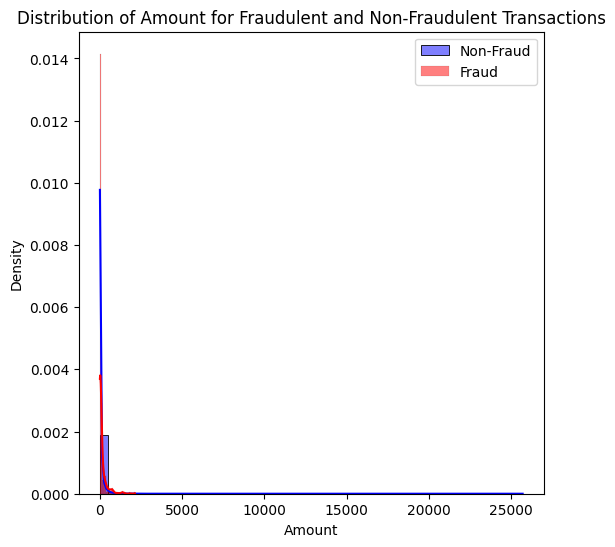

In [17]:
features = [column for column in df.columns if column != 'Class']

for feature in features:
    plt.figure(figsize=(6, 6))
    sns.histplot(df[df['Class'] == 0][feature], color='blue', kde=True, label='Non-Fraud', stat="density", bins=50)
    sns.histplot(df[df['Class'] == 1][feature], color='red', kde=True, label='Fraud', stat="density", bins=50)
    plt.title(f'Distribution of {feature} for Fraudulent and Non-Fraudulent Transactions')
    plt.legend()
    plt.show()

In conclusion, we can see here a lot of features are overlapping, others are well separated:

low_overlap_features = ['V4', 'V3', 'V11', 'V10', 'V12', 'V16', 'V17']
high_overlap_features = ['V1', 'V2', 'V5', 'V6', 'V7', 'V8', 'V9', 'V13', 'V15', 'V14', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

I will use this when training the models.

## Scaling data

#### RobustScaler()

In [18]:
scaler = RobustScaler()
minmax_scaler = StandardScaler()

df['scal_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scal_time'] = minmax_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [19]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scal_amount,scal_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-1.996541


In [20]:
new_df = df.copy()

X = new_df.drop('Class', axis=1)
y = new_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training set target distribution:
Class
0    227451
1       394
Name: count, dtype: int64
Test set target distribution:
Class
0    56864
1       98
Name: count, dtype: int64


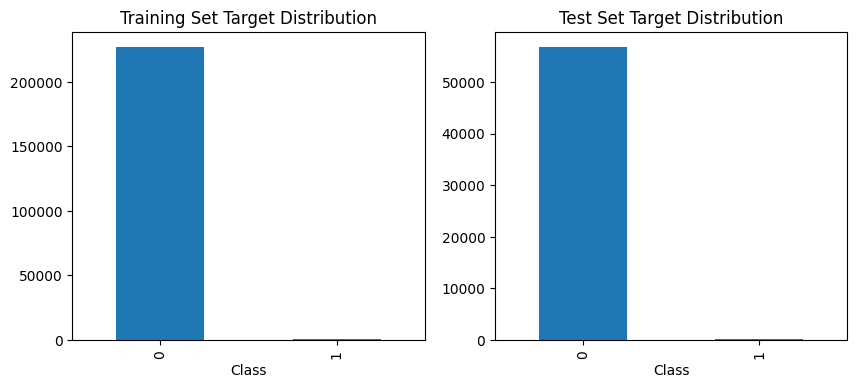

In [21]:
print("Training set target distribution:")
print(y_train.value_counts())

print("Test set target distribution:")
print(y_test.value_counts())

# Visualize the class distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Training Set Target Distribution')
plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar', title='Test Set Target Distribution')
plt.show()

#### As we can see the dataset is very unbalanced and this will cause wrong correlations and bad scores in our model's performance. So, first, I will balance this data to further analysis and predictions.

### Balance data

In [22]:
new_df = new_df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = new_df.loc[df['Class'] == 1]
non_fraud_df = new_df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scal_amount,scal_time
137036,1.095644,-0.321572,0.685500,-0.015383,-0.707208,-0.083963,-0.490198,0.161550,0.204217,-0.035794,...,0.455054,-0.037135,0.093957,0.111081,1.079293,-0.056861,0.003882,0,0.361210,-0.270044
69498,0.385108,1.217620,-1.953872,2.087076,-1.144225,-0.576888,-2.582865,0.643230,-1.191233,-3.095094,...,0.372144,-0.310456,-0.624065,0.840216,-0.159452,0.599482,0.288916,1,-0.195626,-0.871016
213821,-5.892309,-2.189290,-1.118366,-0.229625,0.156316,1.787939,-0.017062,1.349689,0.160927,-0.754414,...,-1.048880,0.358481,-0.892652,0.262514,0.268586,-1.682060,1.137816,0,1.042688,0.939039
43624,-1.048005,1.300219,-0.180401,2.589843,-1.164794,0.031823,-2.175778,0.699072,-1.140208,-3.226787,...,0.624321,-0.136663,0.131738,0.030921,-0.176701,0.504898,0.069882,1,0.243834,-1.120952
234632,1.261324,2.726800,-5.435019,5.342759,1.447043,-1.442584,-0.898702,0.123062,-2.748496,-3.202436,...,-0.425938,-0.154440,-0.018820,0.632234,0.192922,0.468181,0.280486,1,-0.285195,1.121106


I used the undersampling method because it randomly removes instances from the majority class until the class distribution is balanced. For this dataset I think is the best choice to not create bias

Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


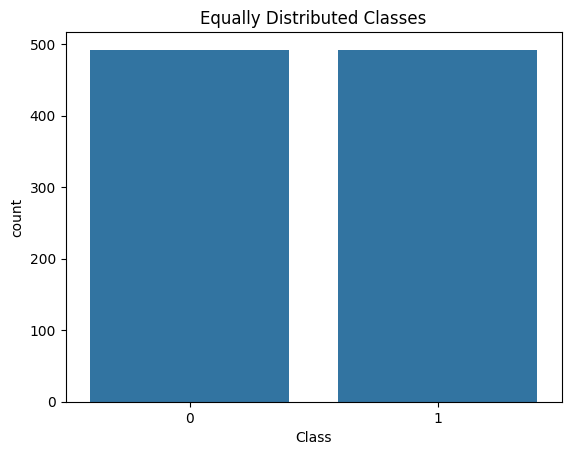

In [23]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot(data=new_df, x='Class')
plt.title('Equally Distributed Classes')
plt.show()

### Check the correlation between features

<Axes: >

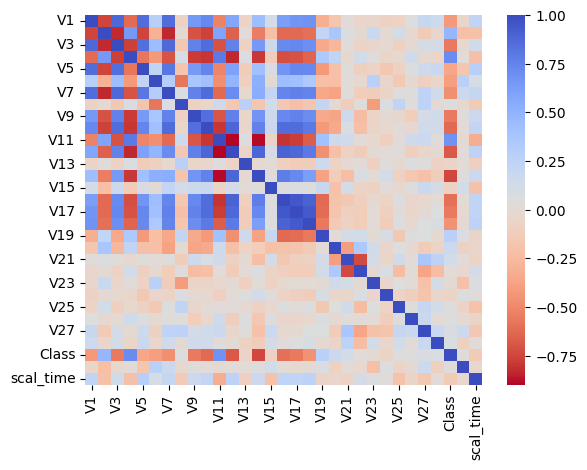

In [24]:
corr = new_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

In [25]:
corr = new_df.corr()
corr[['Class']]
corr[corr.Class < -0.6]['Class']

V10   -0.626189
V12   -0.686426
V14   -0.749702
Name: Class, dtype: float64

As we can see, we have a negative correlation between the Class and these features. The lower the correlation increases the chances of being a fraud transaction.

In [26]:
corr= new_df.corr()
corr[['Class']]
corr[corr.Class>0.5]['Class']

V4       0.712944
V11      0.686694
Class    1.000000
Name: Class, dtype: float64

Here we have a positive correlation. Higher values of V4 and V11 could mean also an increase of fraud

I choose not to remove the outliers of these features because we are dealing with fraudulent transactions and this could remove some of them present in these outliers.

# Predictive Models

## Logistic Regression

Optimized Logistic Regression Model:
Accuracy: 0.9991222218320986
Recall: 0.5918367346938775
F1-score: 0.6987951807228916


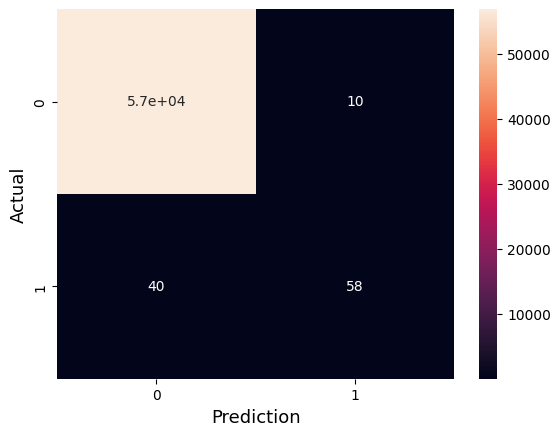

In [73]:
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train, y_train)

log_y_pred = log_model.predict(X_test)

log_accuracy = accuracy_score(y_test, log_y_pred)
log_recall = recall_score(y_test, log_y_pred)
log_f1 = f1_score(y_test, log_y_pred)

print("Optimized Logistic Regression Model:")
print("Accuracy:", log_accuracy)
print("Recall:", log_recall)
print("F1-score:", log_f1)

cm = confusion_matrix(y_test, log_y_pred)
sns.heatmap(cm, annot=True)
plt.ylabel('Actual', fontsize=13)
plt.xlabel('Prediction', fontsize=13)
plt.show()

In [74]:
log_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Hypertuning Logistic Regression:

In [29]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

log_model = LogisticRegression(max_iter=100)
grid_search = GridSearchCV(log_model, param_grid, cv=2, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

Best parameters found:  {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


Optimized Logistic Regression Model:
Accuracy: 0.9991222218320986
Recall: 0.5816326530612245
F1-score: 0.6951219512195121


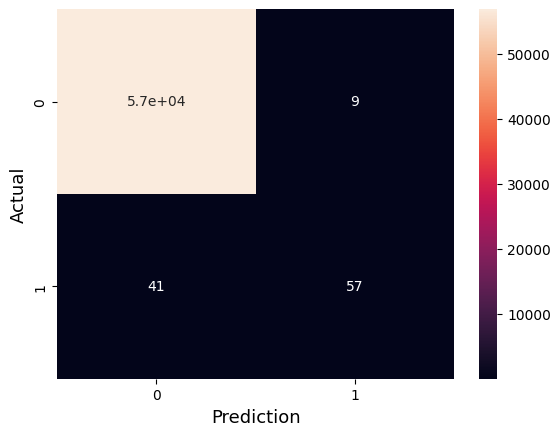

In [58]:
best_log_model = LogisticRegression(C=10, penalty='l2', solver='newton-cg', max_iter=1000)
best_log_model.fit(X_train, y_train)

log_y_pred = best_log_model.predict(X_test)

log_accuracy = accuracy_score(y_test, log_y_pred)
log_recall = recall_score(y_test, log_y_pred)
log_f1 = f1_score(y_test, log_y_pred)

print("Optimized Logistic Regression Model:")
print("Accuracy:", log_accuracy)
print("Recall:", log_recall)
print("F1-score:", log_f1)

cm = confusion_matrix(y_test, log_y_pred)
sns.heatmap(cm, annot=True)
plt.ylabel('Actual', fontsize=13)
plt.xlabel('Prediction', fontsize=13)
plt.show()

After multiple tries, no improvements have been seen.

In [75]:
import pickle

with open('../CCFraud_project/logistic_regression_model.sav', 'wb') as f:
    pickle.dump(log_model, f)

## Random Forest

Random Forest Model:
Accuracy: 0.9995786664794073
Recall: 0.7755102040816326
F1-score: 0.8636363636363636


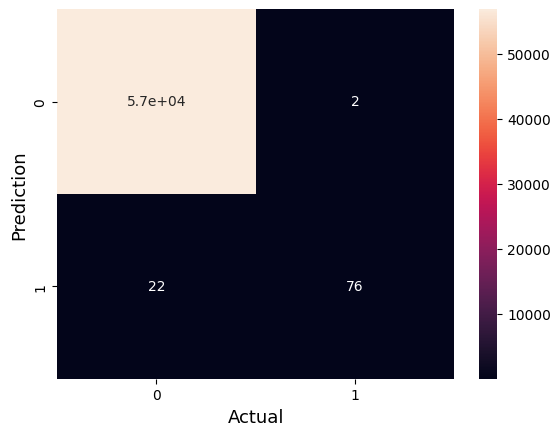

In [31]:
rf_model = RandomForestClassifier()

rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)

print("Random Forest Model:")
print("Accuracy:", rf_accuracy)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)

cm = confusion_matrix(y_test, rf_y_pred)
sns.heatmap(cm, annot=True)
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.show()

Here with Random Forest model, we already obtain very good results with higher scores for the f1-score of 87%. And if we observe, only 2 of the data has been wrongly predicted as non-fraudulent when it was actually fraudulent.

In [70]:
with open('../CCFraud_project/random_forest_model.sav', 'wb') as f:
    pickle.dump(rf_model, f)

## SVM

Random Forest Model:
Accuracy: 0.999385555282469
Recall: 0.6632653061224489
F1-score: 0.7878787878787878


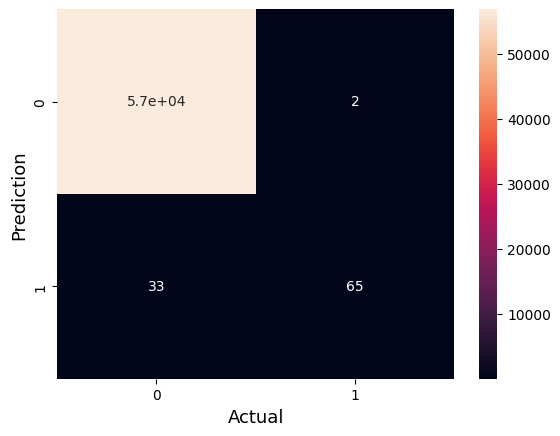

In [76]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train, y_train)
svc_y_pred = svc_model.predict(X_test)

svc_accuracy = accuracy_score(y_test, svc_y_pred)
svc_recall = recall_score(y_test, svc_y_pred)
svc_f1 = f1_score(y_test, svc_y_pred)

print("SVM:")
print("Accuracy:", svc_accuracy)
print("Recall:", svc_recall)
print("F1-score:", svc_f1)

cm = confusion_matrix(y_test, svc_y_pred)
sns.heatmap(cm, annot=True)
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.show()

In [77]:
with open('../CCFraud_project/svc_model.sav', 'wb') as f:
    pickle.dump(svc_model, f)

## FNN model

In [85]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(10, input_shape=(X_train.shape[1],), activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [86]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [87]:
model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step - loss: 0.1076
Epoch 2/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 241us/step - loss: 0.0068
Epoch 3/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step - loss: 0.0053
Epoch 4/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 233us/step - loss: 0.0046
Epoch 5/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 235us/step - loss: 0.0046
Epoch 6/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 248us/step - loss: 0.0047
Epoch 7/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step - loss: 0.0043
Epoch 8/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 233us/step - loss: 0.0047
Epoch 9/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step - loss: 0.0042
Epoch 10/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 232us/step - loss: 0.0042
Epoch 11/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step - loss: 0.0041
Epoch 12/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 233us/step - loss: 0.0043
Epoch 13/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 241us/step - loss: 0.0040
Epoch 14/100
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step - 

In [91]:
y_pred = model.predict(X_test)
y_pred = np.around(y_pred)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step


Neural Network Model:
Accuracy: 0.9992977774656788
Recall: 0.7857142857142857
F1-score: 0.7938144329896907


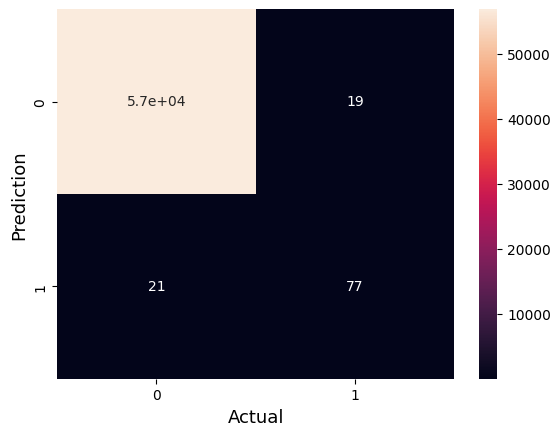

In [92]:
model_accuracy = accuracy_score(y_test, y_pred)
model_recall = recall_score(y_test, y_pred)
model_f1 = f1_score(y_test, y_pred)

print("Neural Network Model:")
print("Accuracy:", model_accuracy)
print("Recall:", model_recall)
print("F1-score:", model_f1)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.show()

In [93]:
with open('../CCFraud_project/FNN_model.sav', 'wb') as f:
    pickle.dump(model, f)